<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/TheThematics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Thematic map

Last session we created a file with several layers:

In [1]:
import geopandas as gpd

linkGit='https://github.com/Camila-Ramirez-Datos-espaciales/evaluacion1/raw/refs/heads/main/'
linkWorldMaps='worldMaps.gpkg'

we can easily find out the layers in that geopackage file (**worldMaps.gpkg**):

In [2]:
gpd.list_layers(linkGit+linkWorldMaps)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


For the thematics we will retrieve only one layer (map):

In [3]:
countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

# see some
countries

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


As you see, the GDF above has just two colums; enough to plot a map, but no more than that.

Let me open a DF:

In [4]:
import pandas as pd

someDataLink='FAOSTAT_data_en_9-12-2025.csv'

someData=pd.read_csv(linkGit+someDataLink)

## data available
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       56 non-null     object 
 1   Domain            56 non-null     object 
 2   Area Code (M49)   56 non-null     int64  
 3   Country           56 non-null     object 
 4   Element Code      56 non-null     int64  
 5   Element           56 non-null     object 
 6   Item Code         56 non-null     int64  
 7   Item              56 non-null     object 
 8   Year Code         56 non-null     int64  
 9   Year              56 non-null     int64  
 10  Unit              56 non-null     object 
 11  Value             55 non-null     float64
 12  Flag              56 non-null     object 
 13  Flag Description  56 non-null     object 
 14  region            56 non-null     object 
 15  sq_km             56 non-null     int64  
dtypes: float64(1), int64(6), object(9)
memory usag

## Pre Processing: Merging

The DF has some interesting numerical data (_float64_):
* fragility: fragility index 2023 -[details here](https://fragilestatesindex.org/2023/06/14/fragile-states-index-2023-annual-report/)
* co2: metric tonnes of CO2 emmitted -[details here](https://www.cia.gov/the-world-factbook/field/carbon-dioxide-emissions/country-comparison/)
* sq_km: country area -[details here](https://www.cia.gov/the-world-factbook/field/area/country-comparison/)
* num_airports: count of airports in the country -[details here](https://www.cia.gov/the-world-factbook/field/airports/country-comparison/)
* population: country population  -[details here](https://www.cia.gov/the-world-factbook/field/population/country-comparison/)
* mobiles: total number of mobile cellular telephone subscribers -[details here](https://www.cia.gov/the-world-factbook/field/telephones-mobile-cellular/country-comparison/)

There are also other columns that may be of help:

In [5]:
someData.head()

,Domain Code,Domain,Area Code (M49),Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,region,sq_km
0,BE,Bioenergy,8,Albania,5851,Energy consumption,6521,Biodiesel,2023,2023,TJ,5888.0,X,Figure from external organization,Europe,28748
1,BE,Bioenergy,32,Argentina,5851,Energy consumption,6521,Biodiesel,2023,2023,TJ,21712.0,X,Figure from external organization,South America,2780400
2,BE,Bioenergy,36,Australia,5851,Energy consumption,6521,Biodiesel,2023,2023,TJ,38.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Oceania,7688287
3,BE,Bioenergy,40,Austria,5851,Energy consumption,6521,Biodiesel,2023,2023,TJ,348.0,X,Figure from external organization,Europe,83879
4,BE,Bioenergy,112,Belarus,5851,Energy consumption,6521,Biodiesel,2023,2023,TJ,589.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Europe,207600


Preparing thematic maps requires **social data** _about_ the geometry (line, polygon, point). The object **countries** has no social data, so the preprocessing requires geomerging.

### Geo Merging

This is a critical preprocessing operation, as it is in charge of combining data sets, in this case combine a DF into a GDF. Some rules are needed:

* There is at least one common column needed to serve for the matches.
* The common columns, or KEYs, need contents to be written exactly in both columns.
* It is recommended that both KEYs are named the same.

Here we have the KEYs:

In [6]:
countries.COUNTRY.head()

,COUNTRY
0,Aruba (Netherlands)
1,Antigua and Barbuda
2,Afghanistan
3,Algeria
4,Azerbaijan


In [7]:
someData.Country.head()

,Country
0,Albania
1,Argentina
2,Australia
3,Austria
4,Belarus


Let's solve the _country name_ differences for the KEYs:

In [8]:
countries.rename(columns={'COUNTRY':'Country'},inplace=True)

It is very unlikely the names are written the same. Let's verify:

In [9]:
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

Check here:

In [10]:
onlyDF # they did not find a match in the MAP GDF!

{'Bermuda',
 'China, mainland',
 'Czechia',
 'Netherlands (Kingdom of the)',
 'North Macedonia',
 'Republic of Korea',
 'Türkiye',
 'United Kingdom of Great Britain and Northern Ireland',
 'United States of America'}

There are several countries in the DF that did not find a match in the GDF (map). Of course, most of them are in the map, let's see why they were not matched.



```
# Tiene formato de código
```

### Fuzzy merging

We use this technique to detect similarities between strings. You need this package **thefuzz** (based on the [Levenshtein algorithm](https://en.wikipedia.org/wiki/Levenshtein_distance)):

In [11]:
!pip install thefuzz

This is the basic idea:

In [12]:
from thefuzz.process import extractOne as best

## find the BEST match to 'BAHAMAS (THE)'
## from all strings in 'onlyGDF'

best('BAHAMAS (THE)',onlyGDF)

('Bahamas', 90)

As you see, you get a coefficient value of 90 (the closer to 100 the better). That may be a reliable result.

Let's do the same for all the unmatched countries:

In [13]:
## for each country in onlyDF, find the BEST match in onlyGDF

[(country, best(country,onlyGDF)) for country in onlyDF]

[('Republic of Korea', ('Federated States of Micronesia', 86)),
 ('United States of America', ('United States', 90)),
 ('Bermuda', ('Bermuda (UK)', 90)),
 ('Czechia', ('Czech Republic', 75)),
 ('Türkiye', ('Turkey', 67)),
 ('Netherlands (Kingdom of the)', ('Netherlands', 90)),
 ('North Macedonia', ('Macedonia', 90)),
 ('United Kingdom of Great Britain and Northern Ireland',
  ('United Kingdom', 90)),
 ('China, mainland', ('Oman', 68))]

Each element in the *list* above in in parentheses, for instance:

```
('TIMOR-LESTE', ('EAST TIMOR', 81))
```

That element has two elements:


*   **'TIMOR-LESTE'** from *onlyDF*, and
*   **('EAST TIMOR', 81)** which is the result from _best(country,onlyGDF)_. This last element, as we just saw above, shows the best match and the level of similarity (the higher the more similar).

We can prepare a list where each element has three elements:



In [14]:
#or
[(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]

[('Republic of Korea', 'Federated States of Micronesia', 86),
 ('United States of America', 'United States', 90),
 ('Bermuda', 'Bermuda (UK)', 90),
 ('Czechia', 'Czech Republic', 75),
 ('Türkiye', 'Turkey', 67),
 ('Netherlands (Kingdom of the)', 'Netherlands', 90),
 ('North Macedonia', 'Macedonia', 90),
 ('United Kingdom of Great Britain and Northern Ireland',
  'United Kingdom',
  90),
 ('China, mainland', 'Oman', 68)]

For instace, this element has 3 elements:

```
 ('IRAN (ISLAMIC REPUBLIC OF)', 'IRAN', 90)
```

The level of similarity would guide us to make update (replace) the strings in one of the KEYs, so that the merging process works properly.

Then, it would be better if we have a data frame instead of a list:

In [15]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF])

,0,1,2
0,Republic of Korea,Federated States of Micronesia,86
1,United States of America,United States,90
2,Bermuda,Bermuda (UK),90
3,Czechia,Czech Republic,75
4,Türkiye,Turkey,67
5,Netherlands (Kingdom of the),Netherlands,90
6,North Macedonia,Macedonia,90
7,United Kingdom of Great Britain and Northern I...,United Kingdom,90
8,"China, mainland",Oman,68


Let's sort by the column '2' (the third):

In [16]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(by=2)

,0,1,2
4,Türkiye,Turkey,67
8,"China, mainland",Oman,68
3,Czechia,Czech Republic,75
0,Republic of Korea,Federated States of Micronesia,86
2,Bermuda,Bermuda (UK),90
5,Netherlands (Kingdom of the),Netherlands,90
6,North Macedonia,Macedonia,90
1,United States of America,United States,90
7,United Kingdom of Great Britain and Northern I...,United Kingdom,90


The previous result helps make a plan based on these cases:
* **ESWATINI** is always a problem, because it is also *SWAZILAND*.
* **KOREA (THE REPUBLIC OF)** is not _NORTH KOREA_.
* **LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)** is too long to match *LAOS* (if it exists in the map like that).
* **SAMOA** is always a problem, because it is also *WESTERN SAMOA*.

Based on this, we should see what our GDF has:

In [17]:
countries.Country[countries.Country.str.contains('SWAZ|LAO|SAMOA|KORE')]

,Country


Then, it makes sense to change those manually (notice the 'replace' uses Python dictionaries):

In [18]:
# this is a {dictionary}

manualChanges={'SWAZILAND':'ESWATINI',
               'LAOS':"LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
               'SOUTH KOREA':'KOREA (THE REPUBLIC OF)',
               'WESTERN SAMOA':'SAMOA',
              }

countries.replace(to_replace={'Country':manualChanges},inplace=True)

At this stage, we should recompute the differences:

In [19]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

An re run this code:

In [20]:
# keeping high scores

pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(2)

,0,1,2
4,Türkiye,Turkey,67
8,"China, mainland",Oman,68
3,Czechia,Czech Republic,75
0,Republic of Korea,Federated States of Micronesia,86
2,Bermuda,Bermuda (UK),90
5,Netherlands (Kingdom of the),Netherlands,90
6,North Macedonia,Macedonia,90
1,United States of America,United States,90
7,United Kingdom of Great Britain and Northern I...,United Kingdom,90


All this is correct now!

Let's prepare the changes:

In [21]:
# new {dictionary}
changesToDF={country: best(country,onlyGDF)[0] for country in onlyDF}
changesToDF

{'Republic of Korea': 'Federated States of Micronesia',
 'United States of America': 'United States',
 'Bermuda': 'Bermuda (UK)',
 'Czechia': 'Czech Republic',
 'Türkiye': 'Turkey',
 'Netherlands (Kingdom of the)': 'Netherlands',
 'North Macedonia': 'Macedonia',
 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
 'China, mainland': 'Oman'}

In [22]:
someData.replace(to_replace={'Country':changesToDF},inplace=True)

What is left to match?

In [23]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)
[(country, best(country,onlyGDF)) for country in onlyDF]

[]

In [24]:
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       56 non-null     object 
 1   Domain            56 non-null     object 
 2   Area Code (M49)   56 non-null     int64  
 3   Country           56 non-null     object 
 4   Element Code      56 non-null     int64  
 5   Element           56 non-null     object 
 6   Item Code         56 non-null     int64  
 7   Item              56 non-null     object 
 8   Year Code         56 non-null     int64  
 9   Year              56 non-null     int64  
 10  Unit              56 non-null     object 
 11  Value             55 non-null     float64
 12  Flag              56 non-null     object 
 13  Flag Description  56 non-null     object 
 14  region            56 non-null     object 
 15  sq_km             56 non-null     int64  
dtypes: float64(1), int64(6), object(9)
memory usag

In [25]:
countries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Country   252 non-null    object  
 1   geometry  252 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.1+ KB


Once you are here, merging can proceed:

In [26]:
## GDF to the 'left'
#theMapAndData=countries.merge(someData, on='Country')
theMapAndData = countries.merge(someData, on='Country', how='left')


In [27]:
theMapAndData.tail()

,Country,geometry,Domain Code,Domain,Area Code (M49),Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,region,sq_km
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832...",BE,Bioenergy,360.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,339014.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Southeast Asia,1904569.0
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,Bonaire (Netherlands),"MULTIPOLYGON (((-68.19736 12.22264, -68.19292 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And our GDF has social data now!

In [28]:
theMapAndData['Value'] = theMapAndData['Value'].fillna(0)


In [29]:
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           252 non-null    object  
 1   geometry          252 non-null    geometry
 2   Domain Code       56 non-null     object  
 3   Domain            56 non-null     object  
 4   Area Code (M49)   56 non-null     float64 
 5   Element Code      56 non-null     float64 
 6   Element           56 non-null     object  
 7   Item Code         56 non-null     float64 
 8   Item              56 non-null     object  
 9   Year Code         56 non-null     float64 
 10  Year              56 non-null     float64 
 11  Unit              56 non-null     object  
 12  Value             252 non-null    float64 
 13  Flag              56 non-null     object  
 14  Flag Description  56 non-null     object  
 15  region            56 non-null     object  
 16  sq_km             

We should save this map of countries and their indicators in a new file:

In [30]:
theMapAndData.to_file("worldindicators.json")

# Thematics: the DDM (Dot Density Map)

You have a DDM if you use dot to show comparatively which polygon of a map has 'more' (or 'less') of some countable phenomenon of interest.
A dot is an aggregated value, but it is constant for each dot.

We have the world map, let's keep Africa:

In [31]:
theMapAndData.region.value_counts()

,count
region,
Europe,35
South America,5
Southeast Asia,4
East Asia,3
Noth America,3
Oceania,2
Midde East,2
Caribbean,1
South Asia,1


### Preprocessing: Filtering

<Axes: >

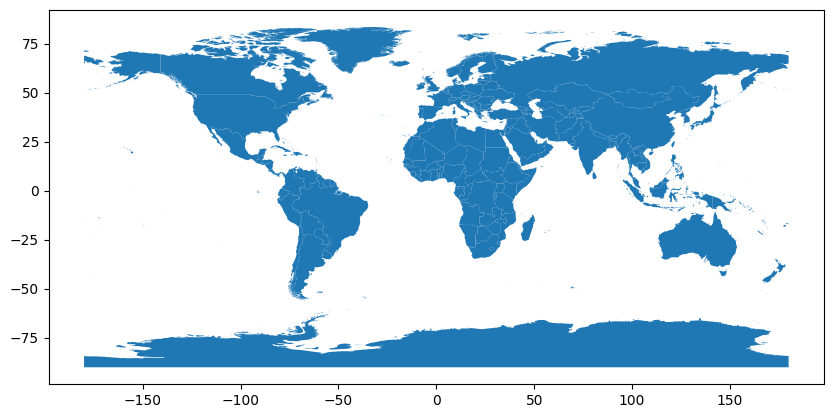

In [32]:
# then
theMapAndData.plot(figsize=(10,15))

A DDM can serve as an effective way to show the distribution of people. The most critical tasks are:

* Dot Placement: The dots should be randomly distributed within each polygon to avoid misrepresenting the data.

* Dot Unit: Deciding how many people each dot should represent is key for visual clarity. This value should be chosen carefully to avoid oversaturation or sparsity.

The size of all dots on the map must be the same to ensure a consistent visual comparison.

### Preprocessing: aggregating

This is a DOT UNIT proposal:

In [33]:
justDots=theMapAndData.copy()
dot_value = 100
justDots['num_dots'] = (justDots['Value'] / dot_value).astype(int, errors='ignore')

### Preprocessing: distributing dots

And here, we get a location for the dots:

In [34]:
# 2. Generate the random dot locations using .sample_points()
justDots = justDots.sample_points(size=justDots['num_dots']).explode(index_parts=True)

You get this:

In [35]:
justDots

5    0        POINT (19.36867 41.93786)
     1        POINT (19.36888 42.23708)
     2         POINT (19.3921 40.66503)
     3         POINT (19.4621 41.37471)
     4        POINT (19.47351 42.14485)
                        ...            
248  3385    POINT (140.96063 -7.92702)
     3386     POINT (140.96773 -3.8141)
     3387    POINT (140.97368 -2.81972)
     3388     POINT (140.9841 -4.17627)
     3389    POINT (140.99334 -3.19119)
Name: sampled_points, Length: 23269, dtype: geometry

In [36]:
# what is it?
type(justDots)

geopandas.geoseries.GeoSeries

### Preprocessing: building GDF from GS

Notice the multi index (MI), one for a country and for a dot. As we are planing to send these points to R, we avoid MI:

In [37]:
justDots.reset_index(drop=True, inplace=True)
world_dots = gpd.GeoDataFrame(geometry=justDots)
world_dots

,geometry
0,POINT (19.36867 41.93786)
1,POINT (19.36888 42.23708)
2,POINT (19.3921 40.66503)
3,POINT (19.4621 41.37471)
4,POINT (19.47351 42.14485)
...,...
23264,POINT (140.96063 -7.92702)
23265,POINT (140.96773 -3.8141)
23266,POINT (140.97368 -2.81972)
23267,POINT (140.9841 -4.17627)


Now you have a GDF:

In [38]:
world_dots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23269 entries, 0 to 23268
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  23269 non-null  geometry
dtypes: geometry(1)
memory usage: 181.9 KB


Juts plot the polygons as the base, and the points as the layer on top!

<Axes: >

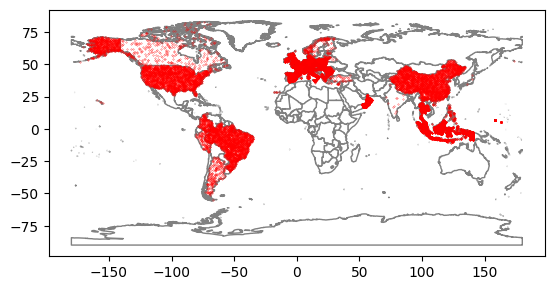

In [39]:
base = theMapAndData.plot(facecolor="white", edgecolor='grey')
world_dots.plot(markersize=0.05, color='red',ax=base)

It is generally recommended that DDMs use an **equal-area projection**, which benefits density and limits area distortion.

<Axes: >

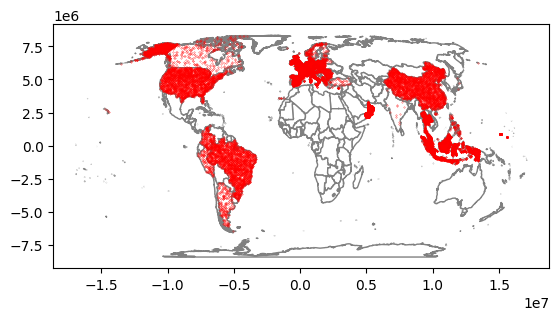

In [40]:
base = theMapAndData.to_crs(8857).plot(facecolor="white", edgecolor='grey')

world_dots.to_crs(8857).plot(markersize=0.05, color='red', ax=base)

Let's keep the continent countries with that crs:

In [41]:
theMapAndData_8857=theMapAndData.to_crs(8857)
world_dots_8857=world_dots.to_crs(8857)

# Thematics: the PSM (Proportional Symbol Map)

You have a PSM if you use a symbol (generally a circle) to show the distribution of a variable per location.
The symbol is an aggregated raw value, and its size varies according to those values. So now we need:

### Preprocessing: GDF of centroids

1. A location for a symbol, generally the polygon centroid.

In [42]:
theMapAndData_8857_centroids = theMapAndData_8857.copy()

# AtheMapAndData_8857_centroids will have a new geometry:
theMapAndData_8857_centroids['geometry'] = theMapAndData_8857_centroids['geometry'].centroid

2. A size of varying values (not constant as in DDMs). Let's use population again.

In [43]:
theMapAndData_8857_centroids['size'] = theMapAndData_8857_centroids['Value'].apply(lambda x: x**0.5/100)

## or
# import numpy as np
# Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: np.log10(x))

We got the basics, then:

<Axes: >

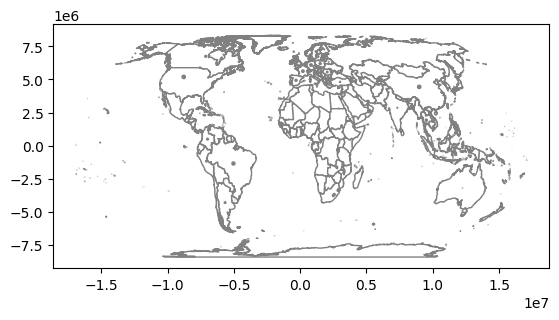

In [44]:
base=theMapAndData_8857.plot(facecolor="white",
                      edgecolor='grey')
# Plot the centroids on top
theMapAndData_8857_centroids.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids['size'],
    color='grey'
)

Keep in mind that the standard way of computing centroids may bring some trouble. Let´s plot Seychelles:

In [45]:
!pip install mapclassify

In [46]:
base=theMapAndData_8857[theMapAndData_8857.Country=="SEYCHELLES"].explore()
theMapAndData_8857_centroids[theMapAndData_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")

/tmp/ipython-input-515609256.py:1: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  base=theMapAndData_8857[theMapAndData_8857.Country=="SEYCHELLES"].explore()
/tmp/ipython-input-515609256.py:2: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  theMapAndData_8857_centroids[theMapAndData_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")


A good alternative to centroids is representative_point() when dealing with complex multipolygons.

In [47]:
# replace the points
theMapAndData_8857_centroids['geometry']=theMapAndData_8857.representative_point()

We will keep that last result.

In [48]:
base=theMapAndData_8857[theMapAndData_8857.Country=="SEYCHELLES"].explore()
theMapAndData_8857_centroids[theMapAndData_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")

/tmp/ipython-input-515609256.py:1: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  base=theMapAndData_8857[theMapAndData_8857.Country=="SEYCHELLES"].explore()
/tmp/ipython-input-515609256.py:2: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  theMapAndData_8857_centroids[theMapAndData_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")


### Preprocessing: Computing new columns

PPMs are not thematic maps to see precise values, but to reveal clear differences on the variable distribution used. As, human eyes are very limited to detect area differences, we may need to use some other tactics to help uncover some patterns.

For example, let's confirm if we have outliers:

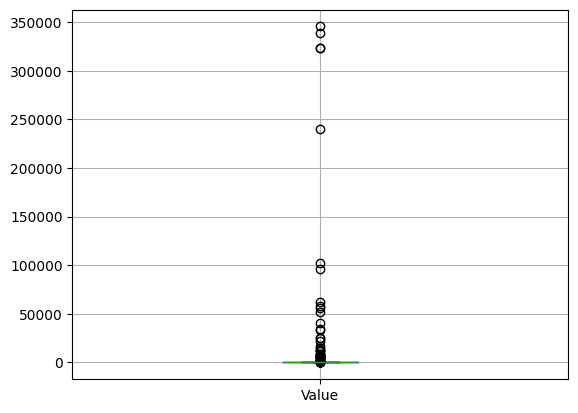

In [49]:
boxplotInfo=theMapAndData_8857_centroids.boxplot(column='Value',return_type="dict")

The object **boxplotInfo** showed the boxplot, and we confirm there are outliers. We can recover them like this:

In [50]:
outliers=boxplotInfo['fliers'][0].get_ydata()
## see
outliers

array([5888.0, 21712.0, 38.0, 348.0, 7.0, 4.0, 589.0, 240324.0, 6879.0,
       33141.0, 323840.0, 25251.0, 1002.0, 6316.0, 8291.0, 911.0, 11592.0,
       1287.0, 25632.0, 102674.0, 1.0, 96306.0, 6207.0, 877.0, 8795.0,
       156.0, 1325.0, 56386.0, 345.0, 95.0, 4166.0, 5520.0, 4476.0, 9.0,
       463.0, 323840.0, 34625.0, 14407.0, 12346.0, 6.0, 11982.0, 40454.0,
       107.0, 17323.0, 7600.0, 3000.0, 51531.0, 1546.0, 1.0, 62560.0,
       3749.0, 58586.0, 345636.0, 4.0, 339014.0], dtype=object)

Then, these are the outlying countries:

In [51]:
theMapAndData_8857_centroids[theMapAndData_8857_centroids.Value.isin(outliers)]

,Country,geometry,Domain Code,Domain,Area Code (M49),Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,region,sq_km,size
5,Albania,POINT (1690025.667 5046293.422),BE,Bioenergy,8.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,5888.0,X,Figure from external organization,Europe,28748.0,0.767333
10,Argentina,POINT (-5553772.712 -4493827.822),BE,Bioenergy,32.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,21712.0,X,Figure from external organization,South America,2780400.0,1.473499
11,Australia,POINT (12169405.639 -3097718.966),BE,Bioenergy,36.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,38.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Oceania,7688287.0,0.061644
12,Austria,POINT (1189005.238 5751150.548),BE,Bioenergy,40.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,348.0,X,Figure from external organization,Europe,83879.0,0.186548
18,Bermuda (UK),POINT (-5740755.39 4038888.931),BE,Bioenergy,60.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,7.0,X,Figure from external organization,Noth America,53.0,0.026458
19,Belgium,POINT (387446.908 6036496.1),BE,Bioenergy,56.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,4.0,X,Figure from external organization,Europe,30689.0,0.020000
27,Belarus,POINT (2149614.456 6346565.463),BE,Bioenergy,112.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,589.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Europe,207600.0,0.242693
29,Brazil,POINT (-4700709.502 -1764170.762),BE,Bioenergy,76.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,240324.0,X,Figure from external organization,South America,8514215.0,4.902285
31,Bulgaria,POINT (2101087.263 5224181.305),BE,Bioenergy,100.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,6879.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Europe,110994.0,0.829397
35,Canada,POINT (-8057335.615 6460418.072),BE,Bioenergy,124.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,33141.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Noth America,9984670.0,1.820467


Knowing this information, we can create a column as outlier flag:

In [52]:
theMapAndData_8857_centroids['Value_outlier']=theMapAndData_8857_centroids.Value.isin(outliers)*1

## see
theMapAndData_8857_centroids

,Country,geometry,Domain Code,Domain,Area Code (M49),Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,region,sq_km,size,Value_outlier
0,Aruba (Netherlands),POINT (-6627435.863 1600262.217),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
1,Antigua and Barbuda,POINT (-5794568.997 2176408.939),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
2,Afghanistan,POINT (5737749.881 4223784.83),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
3,Algeria,POINT (58149.408 3504624.452),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
4,Azerbaijan,POINT (4052504.835 4936297.741),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,South Sudan,POINT (2780382.012 1002979.353),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
248,Indonesia,POINT (10855969.809 11510.466),BE,Bioenergy,360.0,5851.0,Energy consumption,6521.0,Biodiesel,2023.0,2023.0,TJ,339014.0,I,Value \r\nimputed by a\r\nreceiving \r\nagency,Southeast Asia,1904569.0,5.822491,1
249,East Timor,POINT (11979482.349 -1139940.313),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0
250,Curacao (Netherlands),POINT (-6542575.344 1562925.749),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0


We can use that like this:

<Axes: >

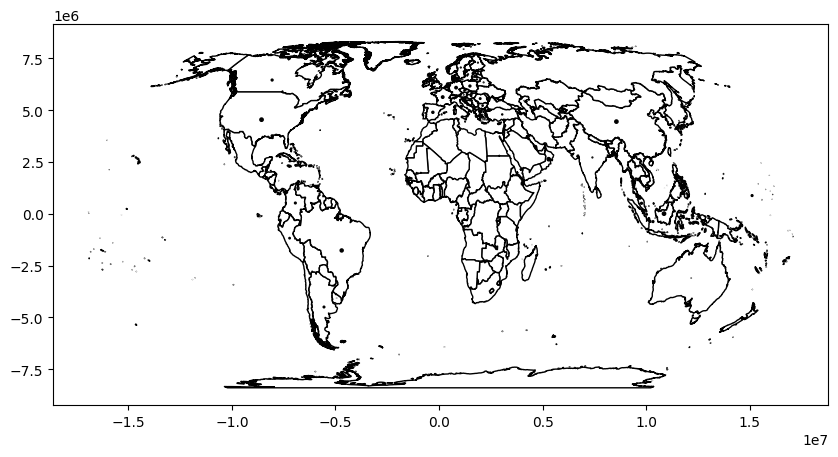

In [53]:
base = theMapAndData_8857.plot(color='white', edgecolor='black', figsize=(10,10))

# Define your color map
mapcolor = {1: 'black', 0: 'lightgrey'}

# Plot the centroids on top
theMapAndData_8857_centroids.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids['size'],
    color=theMapAndData_8857_centroids['Value_outlier'].map(mapcolor)
)

Here, we do a good job for outliers, but it is difficult to interprete the other ones. We could use some redundancy, but more work is needed:
1. Create two maps of centroids:

In [54]:
# Create explicit copies of the DataFrames
theMapAndData_8857_centroids_out = theMapAndData_8857_centroids[theMapAndData_8857_centroids.Value_outlier==1].copy()
theMapAndData_8857_centroids_no_out = theMapAndData_8857_centroids[theMapAndData_8857_centroids.Value_outlier==0].copy()


2. Compute sizes in each:

In [55]:
theMapAndData_8857_centroids_out['size'] = theMapAndData_8857_centroids_out['Value'].apply(lambda x: x**0.5 / 50)
theMapAndData_8857_centroids_no_out['size'] = theMapAndData_8857_centroids_no_out['Value'].apply(lambda x: x**0.5 / 50)

Now, plot the three layers, using some color gradient for the non-outliers:

<Axes: >

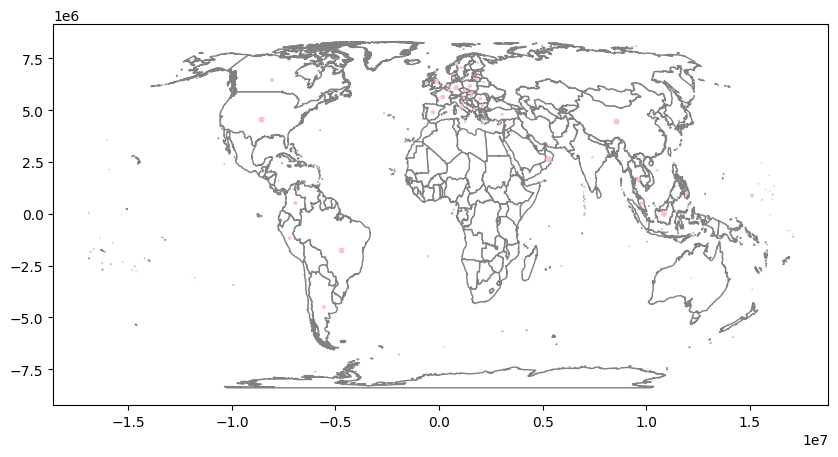

In [56]:
base=theMapAndData_8857.plot(color='white', edgecolor='grey',figsize=(10,10))

theMapAndData_8857_centroids_no_out.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids_no_out['size'],
    edgecolor='grey',
    c=theMapAndData_8857_centroids_no_out['size'],
    cmap='Blues_r'
)
theMapAndData_8857_centroids_out.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids_out['size'],
    color='pink'
)

# Thematics: Choropleths

Notice that the DDMs may use aggregated counts, and the PSMs use the variables in its original form. Choropleths will 'paint' the whole polygon and as noticed in PSMs, we have to be very careful when using color in shape, as the area itself is a confounding. To control this visual artifact, the variable must be normalized, that is, divided by a value correlated with the area.

Then, for this course, a choropleth is a normalized representation of data.

Following our definition:

* This is **NOT** a choropleth:


<Axes: >

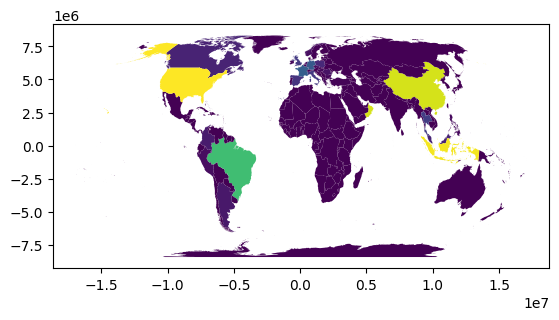

In [57]:
theMapAndData_8857.plot(theMapAndData_8857.Value)

* This **IS** a choropleth:

<Axes: >

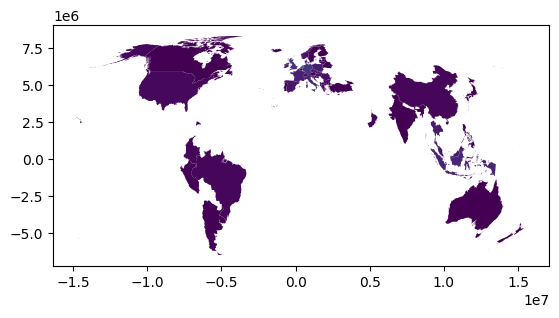

In [102]:
theMapAndData_8857.plot(theMapAndData_8857.Value/theMapAndData_8857.sq_km)


Choropleths are great to represent normalized indicators such as:
* Densities
* Ratios
* Rates
* Averages

Population by area is a density indicator. This is a real number (not an integer), so most of the time the color gradient might  not be
that useful to reveal some pattern visually. Then, we often discretize (or bin) the indicator computed.

### Preprocessing: Discretizing

Now, we want to cut the variable. Run the next code to make sure you have tose packages:

In [100]:
## do you have these installed?
!pip show numba mapclassify numpy

Name: numba
Version: 0.60.0
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: llvmlite, numpy
Required-by: cudf-cu12, cuml-cu12, dask-cuda, distributed-ucxx-cu12, librosa, numba-cuda, pynndescent, shap, stumpy, umap-learn
---
Name: mapclassify
Version: 2.10.0
Summary: Classification Schemes for Choropleth Maps.
Home-page: 
Author: 
Author-email: 
License: BSD 3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: networkx, numpy, pandas, scikit-learn, scipy
Required-by: 
---
Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:


We will discretize this:

In [60]:
theMapAndData_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           252 non-null    object  
 1   geometry          252 non-null    geometry
 2   Domain Code       56 non-null     object  
 3   Domain            56 non-null     object  
 4   Area Code (M49)   56 non-null     float64 
 5   Element Code      56 non-null     float64 
 6   Element           56 non-null     object  
 7   Item Code         56 non-null     float64 
 8   Item              56 non-null     object  
 9   Year Code         56 non-null     float64 
 10  Year              56 non-null     float64 
 11  Unit              56 non-null     object  
 12  Value             252 non-null    float64 
 13  Flag              56 non-null     object  
 14  Flag Description  56 non-null     object  
 15  region            56 non-null     object  
 16  sq_km             

In [65]:
theMapAndData_8857['Value_density']=theMapAndData_8857.Value/theMapAndData_8857.sq_km

In [75]:
theVar = theMapAndData_8857['Value_density'].fillna(0).astype(float)

In [76]:
theVar = theVar[theVar > 0]

In [78]:
import mapclassify
import numpy as np

np.random.seed(12345)

K = 5
# reemplazar NaN y asegurarse que sean floats
theVar = theMapAndData_8857['Value_density'].fillna(0).astype(float)
theVar = theVar[theVar > 0]  # solo valores positivos

# Clasificaciones
ei5 = mapclassify.EqualInterval(theVar, k=K)
msd = mapclassify.StdMean(theVar)
q5 = mapclassify.Quantiles(theVar, k=K)

# Métodos avanzados, solo si hay suficiente variación
try:
    mb5 = mapclassify.MaximumBreaks(theVar, k=K)
except Exception as e:
    print("MaximumBreaks error:", e)

try:
    ht = mapclassify.HeadTailBreaks(theVar)
except Exception as e:
    print("HeadTailBreaks error:", e)

try:
    fj5 = mapclassify.FisherJenks(theVar, k=K)
except Exception as e:
    print("FisherJenks error:", e)

try:
    jc5 = mapclassify.JenksCaspall(theVar, k=K)
except Exception as e:
    print("JenksCaspall error:", e)

try:
    mp5 = mapclassify.MaxP(theVar, k=K)
except Exception as e:
    print("MaxP error:", e)

Let's explore the bining algorithms:

How can we select the right classification?
Let me use the the Absolute deviation around class median (ADCM) to make the comparisson:

In [85]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

Now, plot the **adcms**:

<Axes: ylabel='Classifier'>

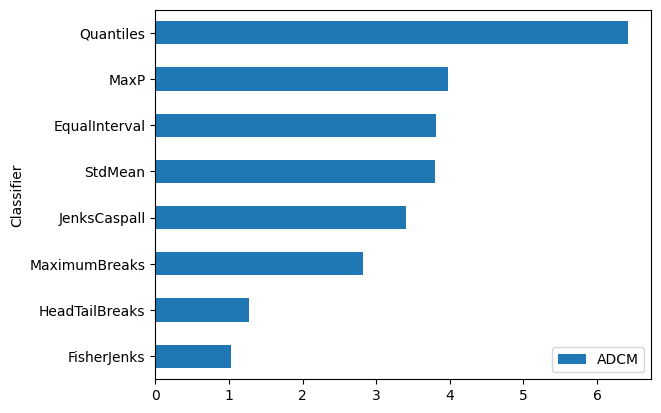

In [86]:
adcms.sort_values('ADCM').plot.barh(x='Classifier')

Let's save the best strategy:

In [87]:
theMapAndData_8857['Value_density_FJ5'] = fj5.yb

In [88]:
# there you are
theMapAndData_8857[['Value_density','Value_density_FJ5']].head(20)

,Value_density,Value_density_FJ5
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
5,0.204814,2
6,NaN,0
7,NaN,0
8,NaN,0
9,NaN,0


We could create a copy of the bins to add labels:

In [90]:
# renaming
newLabelsForLevels={0:"0_VeryLow", 1:"1_Low", 2:"2_Middle", 3:"3_High", 4:"4_VeryHigh"}

theMapAndData_8857['Value_density_FJ5_cat']=theMapAndData_8857.loc[:,'Value_density_FJ5'].replace(newLabelsForLevels)

# we have
theMapAndData_8857[['Value_density','Value_density_FJ5','Value_density_FJ5_cat']].head(20)

,Value_density,Value_density_FJ5,Value_density_FJ5_cat
0,NaN,0,0_VeryLow
1,NaN,0,0_VeryLow
2,NaN,0,0_VeryLow
3,NaN,0,0_VeryLow
4,NaN,0,0_VeryLow
5,0.204814,2,2_Middle
6,NaN,0,0_VeryLow
7,NaN,0,0_VeryLow
8,NaN,0,0_VeryLow
9,NaN,0,0_VeryLow


We are ready for a discrete choropleth:

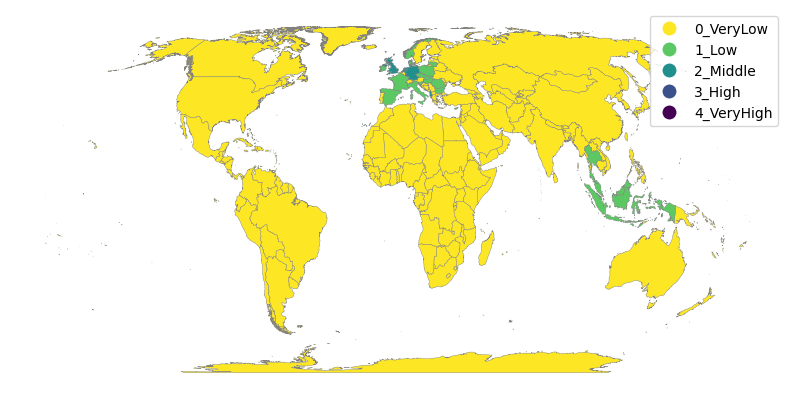

In [91]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
theMapAndData_8857.plot(column='Value_density_FJ5_cat', # variable to plot
                 cmap='viridis_r', # set of colors
                 categorical=True, # can be interpreted as category
                 edgecolor='grey', # border color
                 linewidth=0.3, # width of border
                 legend=True, # need a legend?
                 ax=ax
       )

ax.set_axis_off()

# Saving

Let's save this maps for R.

In [92]:
## Good practice to refresh your memory

## Find only GeoDataFrames in the current session
geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)

List of GeoDataFrames in memory:
countries
_3
theMapAndData
_27
world_dots
_37
theMapAndData_8857
world_dots_8857
theMapAndData_8857_centroids
_51
_52
theMapAndData_8857_centroids_out
theMapAndData_8857_centroids_no_out


These are the ones needed in R:

In [93]:
# for choropleth and base map
theMapAndData_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Country                252 non-null    object  
 1   geometry               252 non-null    geometry
 2   Domain Code            56 non-null     object  
 3   Domain                 56 non-null     object  
 4   Area Code (M49)        56 non-null     float64 
 5   Element Code           56 non-null     float64 
 6   Element                56 non-null     object  
 7   Item Code              56 non-null     float64 
 8   Item                   56 non-null     object  
 9   Year Code              56 non-null     float64 
 10  Year                   56 non-null     float64 
 11  Unit                   56 non-null     object  
 12  Value                  252 non-null    float64 
 13  Flag                   56 non-null     object  
 14  Flag Description       56 non-null

In [94]:
# for DDMs
theMapAndData_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Country                252 non-null    object  
 1   geometry               252 non-null    geometry
 2   Domain Code            56 non-null     object  
 3   Domain                 56 non-null     object  
 4   Area Code (M49)        56 non-null     float64 
 5   Element Code           56 non-null     float64 
 6   Element                56 non-null     object  
 7   Item Code              56 non-null     float64 
 8   Item                   56 non-null     object  
 9   Year Code              56 non-null     float64 
 10  Year                   56 non-null     float64 
 11  Unit                   56 non-null     object  
 12  Value                  252 non-null    float64 
 13  Flag                   56 non-null     object  
 14  Flag Description       56 non-null

In [95]:
# for PSMs
theMapAndData_8857_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           252 non-null    object  
 1   geometry          252 non-null    geometry
 2   Domain Code       56 non-null     object  
 3   Domain            56 non-null     object  
 4   Area Code (M49)   56 non-null     float64 
 5   Element Code      56 non-null     float64 
 6   Element           56 non-null     object  
 7   Item Code         56 non-null     float64 
 8   Item              56 non-null     object  
 9   Year Code         56 non-null     float64 
 10  Year              56 non-null     float64 
 11  Unit              56 non-null     object  
 12  Value             252 non-null    float64 
 13  Flag              56 non-null     object  
 14  Flag Description  56 non-null     object  
 15  region            56 non-null     object  
 16  sq_km             

In [96]:
# for PSMs
theMapAndData_8857_centroids_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55 entries, 5 to 248
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           55 non-null     object  
 1   geometry          55 non-null     geometry
 2   Domain Code       55 non-null     object  
 3   Domain            55 non-null     object  
 4   Area Code (M49)   55 non-null     float64 
 5   Element Code      55 non-null     float64 
 6   Element           55 non-null     object  
 7   Item Code         55 non-null     float64 
 8   Item              55 non-null     object  
 9   Year Code         55 non-null     float64 
 10  Year              55 non-null     float64 
 11  Unit              55 non-null     object  
 12  Value             55 non-null     float64 
 13  Flag              55 non-null     object  
 14  Flag Description  55 non-null     object  
 15  region            55 non-null     object  
 16  sq_km             55 non

In [97]:
# for PSMs
theMapAndData_8857_centroids_no_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 197 entries, 0 to 251
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           197 non-null    object  
 1   geometry          197 non-null    geometry
 2   Domain Code       1 non-null      object  
 3   Domain            1 non-null      object  
 4   Area Code (M49)   1 non-null      float64 
 5   Element Code      1 non-null      float64 
 6   Element           1 non-null      object  
 7   Item Code         1 non-null      float64 
 8   Item              1 non-null      object  
 9   Year Code         1 non-null      float64 
 10  Year              1 non-null      float64 
 11  Unit              1 non-null      object  
 12  Value             197 non-null    float64 
 13  Flag              1 non-null      object  
 14  Flag Description  1 non-null      object  
 15  region            1 non-null      object  
 16  sq_km             1 non

The file **africa_8857.gpkg** will keep all those maps as layers!

In [98]:
theMapAndData_8857.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='continent')
theMapAndData_8857.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='Value_ddm')
theMapAndData_8857_centroids.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='Value_psm')
theMapAndData_8857_centroids_out.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='outlier_Value_psm')
theMapAndData_8857_centroids_no_out.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='no_outlier_Value_psm')